# Initialization / Setup

In [ ]:
!pip install sentence-transformers
!pip install pymupdf
!pip install numpy pandas scikit-Setup

import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 86.0 MB/s eta 0:00:00
GPU Available: True
GPU Device: Tesla T4


In [ ]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import fitz
import os
import pickle
from tqdm import tqdm
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Dataset'
save_path = '/content/drive/MyDrive/reviewer_system/'

os.makedirs(save_path, exist_ok=True)

print(f"✓ Data path: {data_path}")
print(f"✓ Save path: {save_path}")

✓ Data path: /content/drive/MyDrive/Dataset
✓ Save path: /content/drive/MyDrive/reviewer_system/


# Loading Embedding Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Loading model on: {device}")

model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name, device=device)

print(f"✓ Model loaded: {model_name}")
print(f"✓ Embedding dimension: {model.get_sentence_embedding_dimension()}")

Loading model on: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Model loaded: sentence-transformers/all-MiniLM-L6-v2
✓ Embedding dimension: 384


#Pdf Extraction

In [ ]:
def extract_text_from_pdf(pdf_path):
    """Extract text from PDF using PyMuPDF"""
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page_num in range(len(doc)):
            page = doc[page_num]
            text += page.get_text()
        doc.close()

        text = text.strip()
        if len(text) < 100:
            return None
        return text
    except Exception as e:
        print(f"Error: {pdf_path} - {str(e)}")
        return None

In [ ]:
def build_professor_database(data_path):
    """Extract text from all PDFs"""
    professor_papers = {}
    failed_pdfs = []

    professors = [d for d in os.listdir(data_path)
                  if os.path.isdir(os.path.join(data_path, d))]

    print(f"Processing {len(professors)} professors...")

    for prof in tqdm(professors, desc="Extracting PDFs"):
        prof_path = os.path.join(data_path, prof)
        pdf_files = [f for f in os.listdir(prof_path) if f.endswith('.pdf')]

        papers = []
        for pdf_file in pdf_files:
            pdf_path = os.path.join(prof_path, pdf_file)
            text = extract_text_from_pdf(pdf_path)

            if text:
                papers.append({
                    'filename': pdf_file,
                    'text': text[:5000],
                    'full_text': text
                })
            else:
                failed_pdfs.append(pdf_path)

        if papers:
            professor_papers[prof] = papers

    print(f"\n✓ Processed {len(professor_papers)} professors")
    print(f"✓ Total papers: {sum(len(papers) for papers in professor_papers.values())}")
    print(f"✗ Failed: {len(failed_pdfs)}")

    return professor_papers, failed_pdfs

print("✓ PDF extraction functions defined")

✓ PDF extraction functions defined


In [ ]:
professor_papers, failed_pdfs = build_professor_database(data_path)

print("\n=== Sample ===")
for prof, papers in list(professor_papers.items())[:3]:
    print(f"{prof}: {len(papers)} papers")

Processing 71 professors...


Extracting PDFs:  72%|███████▏  | 51/71 [32:04<12:11, 36.59s/it]

MuPDF error: library error: FT_New_Memory_Face(Times-Bold): unknown file format

MuPDF error: library error: FT_New_Memory_Face(Times-Bold): unknown file format



Extracting PDFs: 100%|██████████| 71/71 [41:16<00:00, 34.88s/it]


✓ Processed 71 professors
✓ Total papers: 631
✗ Failed: 7

=== Sample ===
Venkata Dilip Kumar: 9 papers
Yew-Soon Ong: 8 papers
Vidhi Khanduja: 13 papers


In [ ]:
import pickle
with open('/content/drive/MyDrive/reviewer_system/professor_papers.pkl', 'wb') as f:
    pickle.dump(professor_papers, f)
print("✓ Saved extracted papers to Google Drive")

✓ Saved extracted papers to Google Drive


#Generating Embeddings

In [ ]:
def generate_embeddings(professor_papers, model, batch_size=32):
    """Generate embeddings for all papers"""
    professor_embeddings = {}

    print("Generating embeddings...")
    for prof_name, papers in tqdm(professor_papers.items(), desc="Professors"):
        texts = [paper['text'] for paper in papers]

        embeddings = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            device=device
        )

        professor_embeddings[prof_name] = {
            'paper_embeddings': embeddings,
            'paper_filenames': [p['filename'] for p in papers],
            'num_papers': len(papers)
        }

    return professor_embeddings

professor_embeddings = generate_embeddings(professor_papers, model)
print(f"✓ Generated embeddings for {len(professor_embeddings)} professors")

Generating embeddings...


Professors: 100%|██████████| 71/71 [00:03<00:00, 18.40it/s]

✓ Generated embeddings for 71 professors


In [ ]:
def create_professor_profiles(professor_embeddings):
    """Aggregate paper embeddings into professor profiles"""
    profiles = {}

    for prof_name, data in professor_embeddings.items():
        profile_embedding = np.mean(data['paper_embeddings'], axis=0)

        profile_embedding = profile_embedding / np.linalg.norm(profile_embedding)

        profiles[prof_name] = {
            'embedding': profile_embedding,
            'num_papers': data['num_papers'],
            'paper_filenames': data['paper_filenames'],
            'paper_embeddings': data['paper_embeddings']
        }

    return profiles

professor_profiles = create_professor_profiles(professor_embeddings)
print(f"✓ Created {len(professor_profiles)} professor profiles")

with open(f'{save_path}professor_profiles.pkl', 'wb') as f:
    pickle.dump(professor_profiles, f)
print(f"✓ Saved to {save_path}professor_profiles.pkl")

✓ Created 71 professor profiles
✓ Saved to /content/drive/MyDrive/reviewer_system/professor_profiles.pkl


# Metrics

In [ ]:
import numpy as np, re, math, time
from collections import defaultdict

MAX_CHARS = 5000
MIN_TEXT_LEN = 200

def _clean_text(s: str) -> str:
    """Mirror your current behavior: strip + collapse whitespace + truncate to MAX_CHARS."""
    if not s:
        return ""
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s[:MAX_CHARS]

def _l2norm(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    return v / (n + 1e-12)

In [ ]:
import numpy as np

def _maybe_to_vec(x):
    """Return np.float32 vector or None."""
    if x is None:
        return None
    arr = np.asarray(x, dtype=np.float32)
    if arr.ndim == 1 and arr.size > 0:
        return arr
    return None

def _extract_profile_vec_from_obj(obj):
    """
    Try common key variants for a stored author vector in professor_profiles.
    Returns a 1D np.array or None.
    """
    if not isinstance(obj, dict):
        return None
    for key in ("profile_vec", "profile", "embedding", "centroid", "author_vec"):
        v = _maybe_to_vec(obj.get(key, None))
        if v is not None:
            return v
    for k in ("paper_vecs", "paper_embeddings"):
        p = obj.get(k, None)
        if isinstance(p, (list, tuple)) and len(p) > 0:
            try:
                P = np.vstack([np.asarray(v, dtype=np.float32) for v in p if v is not None])
                if P.size > 0:
                    return P.mean(axis=0)
            except Exception:
                pass
    return None

def _embed_texts(texts, batch_size=32):
    """Encode list[str] with your current model & return L2-normalized vectors."""
    if not texts:
        return np.zeros((0, getattr(model, "get_sentence_embedding_dimension", lambda: 384)()), dtype=np.float32)
    vecs = model.encode(texts, normalize_embeddings=True, batch_size=batch_size)
    return np.asarray(vecs, dtype=np.float32)

def _build_profiles_from_papers(ppapers, min_len=MIN_TEXT_LEN, batch_size=32):
    """
    Build author profiles from scratch using professor_papers + model.
    Uses your current 5k-char truncation & normalization, then averages per author.
    """
    author_names_local = []
    author_vecs_local  = []
    skipped = []

    for author, papers in ppapers.items():
        texts = []
        for rec in papers:
            t = _clean_text(rec.get("text", "") or "")
            if len(t) >= min_len:
                texts.append(t)
        if not texts:
            skipped.append((author, "no usable text"))
            continue
        V = _embed_texts(texts, batch_size=batch_size)
        if V.size == 0:
            skipped.append((author, "embedding failed"))
            continue
        prof = V.mean(axis=0)
        prof = _l2norm(prof)
        author_names_local.append(author)
        author_vecs_local.append(prof)

    if not author_vecs_local:
        raise RuntimeError("Could not build any author profiles from professor_papers (all empty?)")
    return author_names_local, np.vstack(author_vecs_local).astype(np.float32), skipped

try:
    author_names
    author_matrix
    print(f"[OK] Using existing author_names (len={len(author_names)}) and author_matrix {author_matrix.shape}.")
except NameError:
    derived_names = []
    derived_vecs  = []
    had_profiles  = False
    if "professor_profiles" in globals() and isinstance(professor_profiles, dict):
        had_profiles = True
        for a, obj in professor_profiles.items():
            v = _extract_profile_vec_from_obj(obj)
            if v is not None:
                derived_names.append(a)
                derived_vecs.append(_l2norm(v))
    if derived_vecs:
        author_names = derived_names
        author_matrix = np.vstack(derived_vecs).astype(np.float32)
        print(f"[OK] Built author_matrix from professor_profiles: {author_matrix.shape} for {len(author_names)} authors.")
    else:
        msg = "[WARN] No valid vectors found in professor_profiles; recomputing from professor_papers."
        if not had_profiles:
            msg = "[INFO] No 'professor_profiles' dict found; building from professor_papers."
        print(msg)
        author_names, author_matrix, skipped = _build_profiles_from_papers(professor_papers, min_len=MIN_TEXT_LEN, batch_size=32)
        print(f"[OK] Built author_matrix from papers: {author_matrix.shape} for {len(author_names)} authors.")
        if skipped:
            print(f"[NOTE] Skipped {len(skipped)} authors with no usable text (showing up to 5): {skipped[:5]}")

[OK] Built author_matrix from professor_profiles: (71, 384) for 71 authors.


In [ ]:
def retrieve_authors_sbert(query_text: str, top_k: int = 10):
    """
    Mirrors your current pipeline:
    - Clean & truncate to MAX_CHARS
    - Encode with your SBERT model (normalized)
    - Cosine similarity vs author centroids (author_matrix)
    """
    text = _clean_text(query_text)
    if not text:
        return []
    q = model.encode(text, normalize_embeddings=True)
    sims = author_matrix @ q
    idx = np.argsort(-sims)[:top_k]
    return [(author_names[i], float(sims[i])) for i in idx]

In [ ]:
def _rank_of_true(ranked_pairs, truth_author):
    """Return 1-based rank of 'truth_author' in ranked_pairs, or None if absent."""
    for r, (a, _) in enumerate(ranked_pairs, start=1):
        if a == truth_author:
            return r
    return None

def metrics_for_query(ranked_pairs, truth_author, k: int = 10):
    """
    With a SINGLE relevant author per query (the folder's author),
    Hit@k == Recall@k, AP@k == 1/r if found (else 0), IDCG == 1 for nDCG.
    """
    r = _rank_of_true(ranked_pairs[:k], truth_author)
    hit = 1 if r is not None else 0
    precision_at_k = hit / k
    recall_at_k = hit
    mrr = (1.0 / r) if r is not None else 0.0
    map_at_k = (1.0 / r) if r is not None else 0.0
    ndcg_at_k = (1.0 / math.log2(1 + r)) if r is not None else 0.0
    return {
        "rank": (r if r is not None else np.inf),
        "hit@k": hit,
        "precision@k": precision_at_k,
        "recall@k": recall_at_k,
        "mrr": mrr,
        "map@k": map_at_k,
        "ndcg@k": ndcg_at_k,
    }

In [ ]:
import pandas as pd

def iter_corpus_from_professor_papers(ppapers: dict):
    """
    Yields (truth_author, paper_id, text) from your already-parsed corpus.
    Skips very short/empty texts to avoid noise.
    Expected shape: professor_papers = { author: [{"path":..., "text":...}, ...], ... }
    """
    for auth, lst in ppapers.items():
        for i, rec in enumerate(lst):
            txt = _clean_text(rec.get("text", ""))
            if len(txt) >= MIN_TEXT_LEN:
                yield auth, f"{auth}__{i}", txt

def evaluate_current_sbert(ppapers: dict, k_list=(1,3,5,10), max_queries=None):
    """
    Evaluates your SBERT-centroid author retrieval on your current corpus.
    Returns: per_query_df (all rows), summary_df (mean metrics per k) with latency stats.
    """
    all_rows = []
    latencies_ms = []
    qcount = 0
    for truth_author, pid, qtext in iter_corpus_from_professor_papers(ppapers):
        qcount += 1
        if max_queries and qcount > max_queries:
            break
        t0 = time.time()
        ranked = retrieve_authors_sbert(qtext, top_k=max(k_list))
        dt = (time.time() - t0) * 1000.0
        latencies_ms.append(dt)
        for k in k_list:
            m = metrics_for_query(ranked, truth_author, k=k)
            all_rows.append({
                "paper_id": pid,
                "truth_author": truth_author,
                "k": k,
                **m
            })

    df = pd.DataFrame(all_rows)
    if df.empty:
        raise RuntimeError("No evaluable papers found (texts too short or corpus empty).")

    agg = (df.groupby("k")[["hit@k","precision@k","recall@k","mrr","map@k","ndcg@k"]]
             .mean().reset_index())
    agg["latency_ms/query_mean"] = float(np.mean(latencies_ms))
    agg["latency_ms/query_p95"]  = float(np.percentile(latencies_ms, 95))
    return df, agg

per_query_df, summary_df = evaluate_current_sbert(professor_papers, k_list=(1,2,3,5,10), max_queries=None)
print(summary_df.round(4))

per_query_df.to_csv("loo_per_query_metrics.csv", index=False)
summary_df.to_csv("loo_summary_metrics.csv", index=False)
print("Saved loo_per_query_metrics.csv and loo_summary_metrics.csv")

    k   hit@k  precision@k  recall@k     mrr   map@k  ndcg@k  \
0   1  0.7892       0.7892    0.7892  0.7892  0.7892  0.7892   
1   2  0.8653       0.4326    0.8653  0.8273  0.8273  0.8372   
2   3  0.9113       0.3038    0.9113  0.8426  0.8426  0.8602   
3   5  0.9461       0.1892    0.9461  0.8505  0.8505  0.8745   
4  10  0.9699       0.0970    0.9699  0.8537  0.8537  0.8822   

   latency_ms/query_mean  latency_ms/query_p95  
0                11.5268               15.9888  
1                11.5268               15.9888  
2                11.5268               15.9888  
3                11.5268               15.9888  
4                11.5268               15.9888  
Saved loo_per_query_metrics.csv and loo_summary_metrics.csv


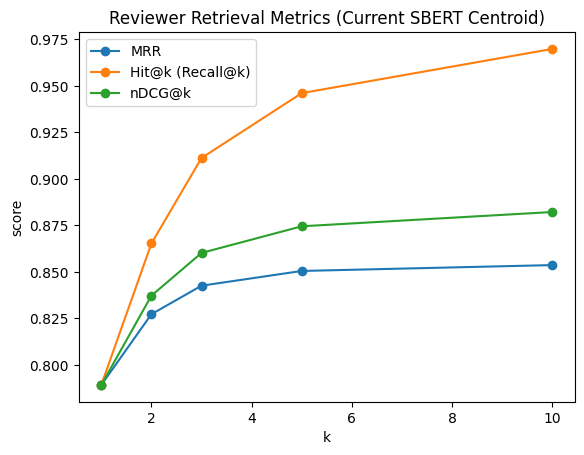

,k,hit@k,precision@k,recall@k,mrr,map@k,ndcg@k,latency_ms/query_mean,latency_ms/query_p95
0,1,0.7892,0.7892,0.7892,0.7892,0.7892,0.7892,11.5268,15.9888
1,2,0.8653,0.4326,0.8653,0.8273,0.8273,0.8372,11.5268,15.9888
2,3,0.9113,0.3038,0.9113,0.8426,0.8426,0.8602,11.5268,15.9888
3,5,0.9461,0.1892,0.9461,0.8505,0.8505,0.8745,11.5268,15.9888
4,10,0.9699,0.0970,0.9699,0.8537,0.8537,0.8822,11.5268,15.9888


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(summary_df["k"], summary_df["mrr"], marker='o', label="MRR")
plt.plot(summary_df["k"], summary_df["hit@k"], marker='o', label="Hit@k (Recall@k)")
plt.plot(summary_df["k"], summary_df["ndcg@k"], marker='o', label="nDCG@k")
plt.xlabel("k")
plt.ylabel("score")
plt.title("Reviewer Retrieval Metrics (Current SBERT Centroid)")
plt.legend()
plt.show()

from IPython.display import display
display(summary_df.round(4))

# New Doc similarity and reviewer recommedation


In [ ]:
def search_reviewers(query_text, professor_profiles, model, top_k=10):
    """
    Find top-k reviewers using cosine similarity.
    """
    query_embedding = model.encode(
        query_text[:5000],
        convert_to_numpy=True,
        device=device
    )
    query_embedding = query_embedding / np.linalg.norm(query_embedding)

    prof_names = list(professor_profiles.keys())
    prof_embeddings = np.array([
        professor_profiles[name]['embedding']
        for name in prof_names
    ])

    similarities = cosine_similarity(
        query_embedding.reshape(1, -1),
        prof_embeddings
    )[0]

    top_k_indices = np.argsort(similarities)[::-1][:top_k]

    results = []
    for rank, idx in enumerate(top_k_indices, 1):
        prof_name = prof_names[idx]
        score = similarities[idx]

        results.append({
            'rank': rank,
            'professor': prof_name,
            'similarity_score': float(score),
            'num_papers': professor_profiles[prof_name]['num_papers'],
            'sample_papers': professor_profiles[prof_name]['paper_filenames'][:3]
        })

    return results

print("✓ Search function defined")

✓ Search function defined


In [ ]:
test_prof = list(professor_papers.keys())[0]
test_text = professor_papers[test_prof][0]['text']

print(f"Testing with paper from: {test_prof}\n")
results = search_reviewers(test_text, professor_profiles, model, top_k=10)

print("="*70)
print("TOP 10 RECOMMENDED REVIEWERS")
print("="*70)

for result in results:
    print(f"\n{result['rank']}. {result['professor']}")
    print(f"   Similarity Score: {result['similarity_score']:.4f}")
    print(f"   Total Papers: {result['num_papers']}")
    print(f"   Sample Papers: {', '.join(result['sample_papers'][:2])}")

Testing with paper from: Venkata Dilip Kumar

TOP 10 RECOMMENDED REVIEWERS

1. Venkata Dilip Kumar
   Similarity Score: 0.6483
   Total Papers: 9
   Sample Papers: Vundekode2021_Chapter_AStudyOnVisionBasedMethodForDa (1).pdf, Crackpaper.pdf

2. Pinaki Chakraborty
   Similarity Score: 0.4042
   Total Papers: 28
   Sample Papers: Compiler bootstrapping and cross-compilation.pdf, Opinion of Engineering Students on the Use of Live Online Lectures.pdf

3. Sulabh Tyagi
   Similarity Score: 0.3503
   Total Papers: 6
   Sample Papers: 978-3-319-57633-6_12.pdf, jase-201809-21-3-0017.pdf

4. Dr.Rohit Beniwal
   Similarity Score: 0.3367
   Total Papers: 6
   Sample Papers: Personality Detection using Kernel-based Ensemble Model for leveraging Social Psychology in Online Networks.pdf, OntologiesforSoftwareEngineering-PastPresentandFuture.pdf

5. Devendra K Tayal
   Similarity Score: 0.3339
   Total Papers: 28
   Sample Papers: A TENGRAM method based part-of-speech tagging of multi-category words i

In [ ]:
from google.colab import files
def upload_and_get_recommendations(professor_profiles, model, top_k=10):
    """Upload a PDF and get reviewer recommendations"""

    print("📄 Please upload a research paper (PDF)...")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded")
        return None

    filename = list(uploaded.keys())[0]
    print(f"\n✓ Uploaded: {filename}")

    print("Extracting text...")
    query_text = extract_text_from_pdf(filename)

    if not query_text:
        print("✗ Failed to extract text from PDF")
        return None

    print(f"✓ Extracted {len(query_text)} characters")

    print("\n🔍 Finding best reviewers...\n")
    results = search_reviewers(query_text, professor_profiles, model, top_k)

    return results, query_text

print("="*70)
print("REVIEWER RECOMMENDATION SYSTEM")
print("="*70 + "\n")

results, query_text = upload_and_get_recommendations(professor_profiles, model, top_k=10)

if results:
    print("\n" + "="*70)
    print("RECOMMENDED REVIEWERS")
    print("="*70 + "\n")

    for result in results:
        print(f"#{result['rank']}: {result['professor']}")
        print(f"   → Similarity: {result['similarity_score']:.4f}")
        print(f"   → Papers: {result['num_papers']}")
        print(f"   → Examples: {', '.join(result['sample_papers'][:2])}")
        print()

REVIEWER RECOMMENDATION SYSTEM

📄 Please upload a research paper (PDF)...


Saving 10_Genomic_data.pdf to 10_Genomic_data.pdf

✓ Uploaded: 10_Genomic_data.pdf
Extracting text...
✓ Extracted 4740 characters

🔍 Finding best reviewers...


RECOMMENDED REVIEWERS

#1: Rudresh dwivedi
   → Similarity: 0.3316
   → Papers: 15
   → Examples: A novel hybrid score level and decision level.pdf, A non-invertible cancelable fingerprint.pdf

#2: Bharghava Rajaram
   → Similarity: 0.3163
   → Papers: 5
   → Examples: Finiteelementanalysisofburiedcontinuouspipelinesubjectedtofaultmotion.pdf, document.pdf

#3: Shikha Gupta
   → Similarity: 0.2876
   → Papers: 6
   → Examples: Efficient data transmission in WSN_ techniques and future challenges.pdf, Ensuring data security in databases using format preserving encryption.pdf

#4: Yew-Soon Ong
   → Similarity: 0.2781
   → Papers: 8
   → Examples: A Multi-Facet Survey on Memetic Computation.pdf, Multifactorial Evolution Towards Evolutionary multitasking.pdf

#5: Himanshu Mittal
   → Similarity: 0.2774
   → Papers: 11
   → Examples: 

In [ ]:
if results:
    df = pd.DataFrame(results)
    csv_path = f'{save_path}recommendations.csv'
    df.to_csv(csv_path, index=False)
    print(f"✓ Saved results to {csv_path}")

    print("\n" + df.to_string(index=False))

✓ Saved results to /content/drive/MyDrive/reviewer_system/recommendations.csv

 rank         professor  similarity_score  num_papers                                                                                                                                                                                                                                                                                                      sample_papers
    1   Rudresh dwivedi          0.331607          15                                                                                                                                                                                         [A novel hybrid score level and decision level.pdf, A non-invertible cancelable fingerprint.pdf, Explainable AI (XAI).pdf]
    2 Bharghava Rajaram          0.316282           5                                                                                                                                                  

# Simple UI


In [ ]:
!pip install -q rich

from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.prompt import Prompt
from rich import box
from rich.progress import Progress
from rich.markdown import Markdown
from google.colab import files
import fitz
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

console = Console()

console.clear()
console.print(Panel.fit(
    "[bold cyan]🎓 AI Reviewer Recommendation System[/bold cyan]\n"
    "[dim]Powered by Sentence Transformers & Semantic Search[/dim]",
    border_style="cyan",
    padding=(1, 4)
))

stats_table = Table(show_header=False, box=box.SIMPLE, padding=(0, 2))
stats_table.add_column("Metric", style="cyan")
stats_table.add_column("Value", style="magenta bold")

total_profs = len(professor_profiles)
total_papers = sum(p['num_papers'] for p in professor_profiles.values())

stats_table.add_row("👥 Professors", str(total_profs))
stats_table.add_row("📄 Total Papers", str(total_papers))
stats_table.add_row("🧠 Model", "all-MiniLM-L6-v2")
stats_table.add_row("📐 Dimensions", "384")

console.print(stats_table)
console.print()

console.rule("[bold blue]📤 Upload Research Paper[/bold blue]")
console.print("\n[yellow]Click 'Choose Files' button below to upload your PDF...[/yellow]\n")

uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    console.print(f"\n[green]✓ Uploaded: {filename}[/green]")

    with Progress() as progress:
        task = progress.add_task("[cyan]Extracting text from PDF...", total=100)

        doc = fitz.open(filename)
        text = ""
        for i, page in enumerate(doc):
            text += page.get_text()
            progress.update(task, advance=100/len(doc))
        doc.close()

    console.print(f"[green]✓ Extracted {len(text):,} characters[/green]\n")

    with Progress() as progress:
        task = progress.add_task("[cyan]Generating embedding...", total=100)
        query_embedding = model.encode(text[:5000], convert_to_numpy=True)
        query_embedding = query_embedding / np.linalg.norm(query_embedding)
        progress.update(task, advance=100)

    console.print("[green]✓ Embedding generated[/green]\n")

    with Progress() as progress:
        task = progress.add_task("[cyan]Searching database...", total=100)

        prof_names = list(professor_profiles.keys())
        prof_embeddings = np.array([
            professor_profiles[name]['embedding']
            for name in prof_names
        ])

        similarities = cosine_similarity(
            query_embedding.reshape(1, -1),
            prof_embeddings
        )[0]

        progress.update(task, advance=100)

    console.print("[green]✓ Search complete[/green]\n")

    top_k = 10
    top_k_indices = np.argsort(similarities)[::-1][:top_k]

    console.rule("[bold blue]🏆 Top 10 Recommended Reviewers[/bold blue]")
    console.print()

    results_table = Table(
        show_header=True,
        header_style="bold magenta",
        box=box.ROUNDED,
        title=f"[bold cyan]Results for: {filename}[/bold cyan]",
        title_style="bold cyan"
    )

    results_table.add_column("Rank", style="cyan bold", width=8, justify="center")
    results_table.add_column("Professor", style="green bold", width=25)
    results_table.add_column("Score", style="yellow", width=10, justify="center")
    results_table.add_column("Papers", style="blue", width=8, justify="center")
    results_table.add_column("Quality", style="white", width=15)

    for rank, idx in enumerate(top_k_indices, 1):
        prof = prof_names[idx]
        score = similarities[idx]
        papers = professor_profiles[prof]['num_papers']

        if score >= 0.7:
            quality = "🔥 Excellent"
            score_style = "bold green"
        elif score >= 0.6:
            quality = "✨ Very Good"
            score_style = "bold yellow"
        elif score >= 0.5:
            quality = "✓ Good"
            score_style = "yellow"
        else:
            quality = "○ Moderate"
            score_style = "white"

        if rank == 1:
            rank_display = "🥇 1"
        elif rank == 2:
            rank_display = "🥈 2"
        elif rank == 3:
            rank_display = "🥉 3"
        else:
            rank_display = str(rank)

        results_table.add_row(
            rank_display,
            prof,
            f"[{score_style}]{score:.4f}[/{score_style}]",
            str(papers),
            quality
        )

    console.print(results_table)
    console.print()

    console.rule("[bold cyan]📚 Top 3 Professors - Sample Papers[/bold cyan]")
    console.print()

    for rank, idx in enumerate(top_k_indices[:3], 1):
        prof = prof_names[idx]
        score = similarities[idx]
        samples = professor_profiles[prof]['paper_filenames'][:3]

        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"

        paper_list = "\n".join([f"📄 {p}" for p in samples])

        console.print(Panel(
            paper_list,
            title=f"[bold green]{medal} {prof}[/bold green] - Score: [yellow]{score:.4f}[/yellow]",
            border_style="green" if rank == 1 else "yellow" if rank == 2 else "blue",
            padding=(0, 2)
        ))

    console.print()
    console.print(Panel(
        "[bold green]✓ Analysis Complete![/bold green]\n\n"
        "Upload another paper to get new recommendations.",
        border_style="green",
        padding=(1, 2)
    ))

else:
    console.print("[red]✗ No file uploaded[/red]")

╭──────────────────────────────────────────────────────────╮
│                                                          │
│    🎓 AI Reviewer Recommendation System                  │
│    Powered by Sentence Transformers & Semantic Search    │
│                                                          │
╰──────────────────────────────────────────────────────────╯

  👥 Professors       71                 
   📄 Total Papers     631                
   🧠 Model            all-MiniLM-L6-v2   
   📐 Dimensions       384               

──────────────────────────────────────────── 📤 Upload Research Paper ─────────────────────────────────────────────

Click 'Choose Files' button below to upload your PDF...

Saving 10_Genomic_data.pdf to 10_Genomic_data (1).pdf


✓ Uploaded: 10_Genomic_data (1).pdf

Output()

✓ Extracted 4,741 characters

Output()

✓ Embedding generated

Output()

✓ Search complete

───────────────────────────────────────── 🏆 Top 10 Recommended Reviewers ─────────────────────────────────────────

                       Results for: 10_Genomic_data (1).pdf                       
╭──────────┬───────────────────────────┬────────────┬──────────┬─────────────────╮
│   Rank   │ Professor                 │   Score    │  Papers  │ Quality         │
├──────────┼───────────────────────────┼────────────┼──────────┼─────────────────┤
│   🥇 1   │ Rudresh dwivedi           │   0.3316   │    15    │ ○ Moderate      │
│   🥈 2   │ Bharghava Rajaram         │   0.3163   │    5     │ ○ Moderate      │
│   🥉 3   │ Shikha Gupta              │   0.2876   │    6     │ ○ Moderate      │
│    4     │ Yew-Soon Ong              │   0.2781   │    8     │ ○ Moderate      │
│    5     │ Himanshu Mittal           │   0.2774   │    11    │ ○ Moderate      │
│    6     │ Krishna Asawa             │   0.2711   │    12    │ ○ Moderate      │
│    7     │ Kastuv Nag                │   0.2694   │    4     │ ○ Moderate      │
│    8     │ Devendra K Tayal          │   0.2657   │    28    │ ○ Moderate      │
│    9     │ Aruna Malapati            │   0.2653   │    13    │ ○ Moderate      │
│    10    │ Dr.Manpreet Kaur          │   0.2649   │    4     │ ○ Moderate      │
╰──────────┴───────────────────────────┴────────────┴──────────┴─────────────────╯

─────────────────────────────────────── 📚 Top 3 Professors - Sample Papers ───────────────────────────────────────

╭────────────────────────────────────── 🥇 Rudresh dwivedi - Score: 0.3316 ───────────────────────────────────────╮
│  📄 A novel hybrid score level and decision level.pdf                                                           │
│  📄 A non-invertible cancelable fingerprint.pdf                                                                 │
│  📄 Explainable AI (XAI).pdf                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────── 🥈 Bharghava Rajaram - Score: 0.3163 ──────────────────────────────────────╮
│  📄 Finiteelementanalysisofburiedcontinuouspipelinesubjectedtofaultmotion.pdf                                   │
│  📄 document.pdf                                                                                                │
│  📄 aspl076-lin.pdf                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────── 🥉 Shikha Gupta - Score: 0.2876 ────────────────────────────────────────╮
│  📄 Efficient data transmission in WSN_ techniques and future challenges.pdf                                    │
│  📄 Ensuring data security in databases using format preserving encryption.pdf                                  │
│  📄 Automated genre classification of books using machine learning and natural language processing.pdf          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│  ✓ Analysis Complete!                                                                                           │
│                                                                                                                 │
│  Upload another paper to get new recommendations.                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# Streamlit


In [ ]:
with open('streamlit_app.py', 'w') as f:
    f.write('''
import streamlit as st
import pickle
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import fitz
import pandas as pd

st.set_page_config(page_title="AI Reviewer Finder", page_icon="🎓", layout="wide")

st.title("🎓 AI Reviewer Recommendation System")
st.markdown("### Find the best reviewers for your research paper")

@st.cache_resource
def load_system():
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    with open('professor_profiles.pkl', 'rb') as f:
        profiles = pickle.load(f)
    return model, profiles

model, professor_profiles = load_system()

st.sidebar.title("📊 Database")
st.sidebar.metric("Professors", len(professor_profiles))
st.sidebar.metric("Total Papers", sum(p['num_papers'] for p in professor_profiles.values()))

uploaded_file = st.file_uploader("📄 Upload Research Paper (PDF)", type=['pdf'])
top_k = st.slider("Number of recommendations", 3, 20, 10)

if uploaded_file and st.button("🔍 Find Reviewers", type="primary"):
    with st.spinner("Analyzing..."):
        with open("temp.pdf", "wb") as f:
            f.write(uploaded_file.getbuffer())

        doc = fitz.open("temp.pdf")
        text = "".join([page.get_text() for page in doc])
        doc.close()

        query_emb = model.encode(text[:5000], convert_to_numpy=True)
        query_emb = query_emb / np.linalg.norm(query_emb)

        prof_names = list(professor_profiles.keys())
        prof_embs = np.array([professor_profiles[n]['embedding'] for n in prof_names])

        sims = cosine_similarity(query_emb.reshape(1, -1), prof_embs)[0]
        top_idx = np.argsort(sims)[::-1][:top_k]

        st.success("✅ Analysis complete!")
        st.markdown("---")

        for rank, idx in enumerate(top_idx, 1):
            prof = prof_names[idx]
            score = sims[idx]
            papers = professor_profiles[prof]['num_papers']

            col1, col2, col3 = st.columns([1, 3, 1])

            medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"#{rank}"

            with col1:
                st.markdown(f"## {medal}")
            with col2:
                st.markdown(f"**{prof}**")
                st.caption(f"Score: {score:.4f} | Papers: {papers}")
            with col3:
                quality = "Excellent" if score >= 0.7 else "Very Good" if score >= 0.6 else "Good" if score >= 0.5 else "Moderate"
                st.markdown(f"*{quality}*")
''')

print("✓ streamlit_app.py created successfully!")

✓ streamlit_app.py created successfully!


In [ ]:
!pip install -q pyngrok
!pip install -q streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.3 MB/s eta 0:00:00


In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/reviewer_system/professor_profiles.pkl',
            '/content/professor_profiles.pkl')

print("✓ Files copied")

import subprocess
subprocess.Popen(['streamlit', 'run', 'streamlit_app.py', '--server.port=8501'])

import time
time.sleep(10)

print("✓ Streamlit is running!")

✓ Files copied
✓ Streamlit starting...
✓ Streamlit is running!


#Addtional : Temporary StreamLit Deployment


We have properly deployed the application in streamlit, the official link is provided in the submission document.
You can ignore this.
This code was just used to quickly test if the app was working correctly by running it temporarily using ngrok and colossus tools, similar to spinning up a Colab notebook for a fast check before full deployment. It helped confirm things were working before the permanent deployment happened

In [ ]:
# from pyngrok import ngrok

# ngrok.kill()

# ngrok.set_auth_token("34TDF3wRh3GznYzULVDuxgIDSFI_72GFPvm3eeuupRQSUaYaK")

# public_url = ngrok.connect(addr=8501, domain="pawnable-overcautiously-taisha.ngrok-free.dev")

# print("=" * 70)
# print("🌐 YOUR STREAMLIT APP IS LIVE!")
# print("=" * 70)
# print(f"🔗 URL: {public_url}")
# print("\n⚠️ Keep this Colab notebook running while using the app")
# print("=" * 70)

🌐 YOUR STREAMLIT APP IS LIVE!
🔗 URL: NgrokTunnel: "https://pawnable-overcautiously-taisha.ngrok-free.dev" -> "http://localhost:8501"

⚠️ Keep this Colab notebook running while using the app


In [ ]:
# ngrok.kill()